# Using logistic regression to predict credit card fraud

In [3]:
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 1000)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.api import add_constant

from statsmodels.regression.linear_model import RegressionResults
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
# Note --  Requires sklearn version .18 or higher  

from sklearn.metrics import r2_score
from collections import Counter
sns.set(style="ticks")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

assert(sys.version_info.major==3),print(sys.version)
# Python 3 or higher is required

## 1. Load in the creditcard data and conduct basic EDA

In [4]:
df = pd.read_csv("creditcard.csv")

In [5]:
# show top 5 lines by default
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


## 2. Normalize the data


In [7]:
def normalize(x):
    num = x - np.min(x)
    denom = np.max(x) - np.min(x)
    return (num / denom)

df.iloc[:, 0:30] = normalize(df.iloc[:, 0:30])

df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,0.252484,0.680908,0.371591,0.635591,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.000000,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,0.381188,0.744342,0.486190,0.641219,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,0.322422,0.706683,0.503854,0.640473,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,0.271817,0.710910,0.487635,0.636372,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,0.236355,0.724477,0.552509,0.608406,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0


## 3. Split the data

In [9]:
## read X and y
y = df.Class
X = df.drop(['Class'],axis=1)

## examine if the data is balanced 
print ('The percentage of fraudulent transactions is {:.3f}%'.format(sum(y)/len(y)*100))

The percentage of fraudulent transactions is 0.173%


In [10]:
## Split train test sets and test the percentage of classes in y
# the stratify parameter in train_test_split makes sure the traing and testing dataset has the same proportion of classes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check the proportions
print ('The percentage of fraudulent transactions in the training data is {:.3f}%'.format(sum(y_train)/len(y_train)*100))
print ('The percentage of fraudulent transactions in the testing data is {:.3f}%'.format(sum(y_test)/len(y_test)*100))


The percentage of fraudulent transactions in the training data is 0.173%
The percentage of fraudulent transactions in the testing data is 0.172%


## 4. Baseline model--Using all predictor variables in a logistic regression

In [25]:
## Establish the baseline logistic regression
## logisticRegressionCV uses stratify mode for train test split by default
logistic_mod = LogisticRegression(C=1000000, fit_intercept=True, penalty = 'l2')
logistic_mod.fit(X_train, y_train)
y_test_pred = logistic_mod.predict_proba(X_test)[:,1]


In [28]:
# evaluate the accuracy measures
predicted = np.round(y_test_pred)
expected = y_test

y_train_pred = logistic_mod.predict_proba(X_train)[:,1]
t_predicted = np.round(y_train_pred)

print(metrics.classification_report(expected, predicted))

print("Training accuracy for Logistic Regression: ", accuracy_score(y_train, t_predicted))
print("Test accuracy for Logistic Regression: ", accuracy_score(expected,predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.83      0.65      0.73        98

avg / total       1.00      1.00      1.00     56962

Training accuracy for Logistic Regression:  0.9992407118874673
Test accuracy for Logistic Regression:  0.9991748885221726


In [21]:
# check the confusion matrix
pd.crosstab(expected,predicted,margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0.0,1.0,All
Actual,,,
0,56851,13,56864
1,34,64,98
All,56885,77,56962


In [18]:
y_test_pred

array([3.53661829e-05, 3.73039474e-05, 4.93023353e-07, ...,
       1.51766394e-05, 2.95955031e-05, 1.31583867e-04])

The area under ROC for baseline logistic is 0.955.


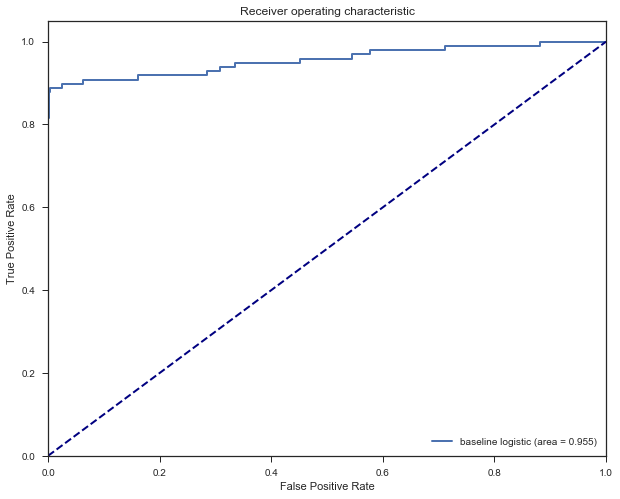

1

In [14]:
# a function to estimate the fpr, tpr and auc
def calc_roc(y_test_list, y_test_pred_list, labels):
    fig = plt.figure(figsize=(10,8))
    lw = 2
    
    for i in range(len(y_test_list)):
        y_test = y_test_list[i]
        y_test_pred = y_test_pred_list[i]
        label = labels[i]
        
        fpr, tpr, _ = metrics.roc_curve(y_test, y_test_pred)
        auc = metrics.auc(fpr,tpr)
        print ('The area under ROC for {} is {:.3f}.'.format(label, auc))

        # draw the ROC
        plt.plot(fpr, tpr, 
                 lw=lw, label='{} (area = {:.3f})'.format(label, auc))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return 1

calc_roc([y_test], [y_test_pred],['baseline logistic'])


## 5.Train a regularized logistic model with the parameter trained using corss validation.

In [15]:
## Tune the regularization parameter C
k = 5 # rounds of kfold-crossvalidation
Cs=list(np.power(10.0, np.arange(-5,5)))
logistic_cv_regularized = LogisticRegressionCV(Cs=Cs, fit_intercept=True, cv = k, penalty = 'l2', scoring='roc_auc')
logistic_cv_regularized.fit(X_train, y_train)

score = logistic_cv_regularized.scores_

print ('Max auc_roc:', logistic_cv_regularized.scores_[1].max(), 'C=', logistic_cv_regularized.C_[0])
score

Max auc_roc: 0.990969556566391 C= 10.0


{1: array([[0.9259631 , 0.92598981, 0.92631148, 0.92880745, 0.94494362,
         0.96064321, 0.97369823, 0.97263223, 0.96808382, 0.96621282],
        [0.9632366 , 0.96330811, 0.96409477, 0.97035988, 0.98714309,
         0.98754045, 0.98764146, 0.98524088, 0.98297108, 0.98171555],
        [0.95074978, 0.95078735, 0.95120029, 0.95507484, 0.97862821,
         0.97907483, 0.97118131, 0.96729007, 0.96448573, 0.96489533],
        [0.95239683, 0.95241185, 0.95262083, 0.95420499, 0.96920647,
         0.97268255, 0.97759446, 0.98114595, 0.98103909, 0.98043303],
        [0.94002176, 0.94006093, 0.94054174, 0.94473877, 0.97257865,
         0.98403988, 0.98843786, 0.99096956, 0.99083428, 0.99074578]])}

The area under ROC for baseline logistic is 0.955.
The area under ROC for regularized logistic is 0.972.


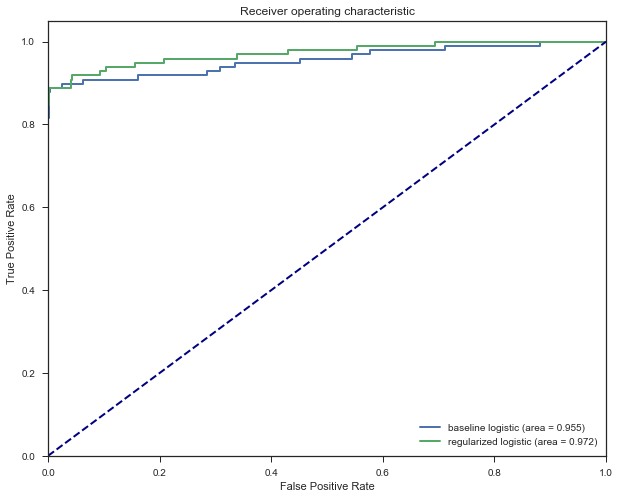

1

In [19]:
# draw the roc curve of the tuned model

# train the model with C=10
logistic_mod_regularized = LogisticRegression(C=10, fit_intercept=True, penalty = 'l2')
logistic_mod_regularized.fit(X_train, y_train)
y_test_pred2 = logistic_mod_regularized.predict_proba(X_test)[:,1]

# draw the ROC
calc_roc([y_test,y_test], [y_test_pred, y_test_pred2],['baseline logistic', 'regularized logistic'])

The results get better.

In [44]:
# evaluate the accuracy measures
predicted2 = np.round(y_test_pred2)
expected = y_test

y_train_pred2 = logistic_mod_regularized.predict_proba(X_train)[:,1]
t_predicted2 = np.round(y_train_pred2)

print(metrics.classification_report(expected, predicted2))

print("Training accuracy for Logistic Regression: ", accuracy_score(y_train, t_predicted2))
print("Test accuracy for Logistic Regression: ", accuracy_score(expected,predicted2))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     56864
          1       0.82      0.61      0.70        98

avg / total       1.00      1.00      1.00     56962

Training accuracy for Logistic Regression:  0.9991968224011938
Test accuracy for Logistic Regression:  0.9991046662687406


###  Accuracy only evaluates the model as the threshold equals 0.5 , therefore it is not a perfect method for evaluating logistic regression.

In [30]:
# check the confusion matrix
pd.crosstab(expected,predicted2,margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0.0,1.0,All
Actual,,,
0,56851,13,56864
1,38,60,98
All,56889,73,56962


## 6. Let's see if oversampling/downsampling makes a difference:

## First, we will try to undersample the majority class.

In [31]:
# perform undersampling to the majority class
from imblearn.under_sampling import RandomUnderSampler
print ('there are {} positive samples among {} samples in the training data.'.format(sum(y_train), len(y_train)))
rus = RandomUnderSampler(random_state=0)
X_train_us, y_train_us = rus.fit_sample(X_train, y_train)
print(sorted(Counter(y_train_us).items()))


there are 394 positive samples among 227845 samples in the training data.
[(0, 394), (1, 394)]


In [32]:
## Tune the regularization parameter C
k = 5 # rounds of kfold-crossvalidation
Cs=list(np.power(10.0, np.arange(-5,5)))
logistic_cv_us = LogisticRegressionCV(Cs=Cs, fit_intercept=True, cv = k, penalty = 'l2', scoring='roc_auc')
logistic_cv_us.fit(X_train_us, y_train_us)

print ('Max auc_roc:', logistic_cv_us.scores_[1].max(), 'C=', logistic_cv_us.C_[0])


Max auc_roc: 0.9963839579224194 C= 100.0


The area under ROC for baseline logistic is 0.955.
The area under ROC for regularized logistic is 0.972.
The area under ROC for undersampled logistic is 0.977.


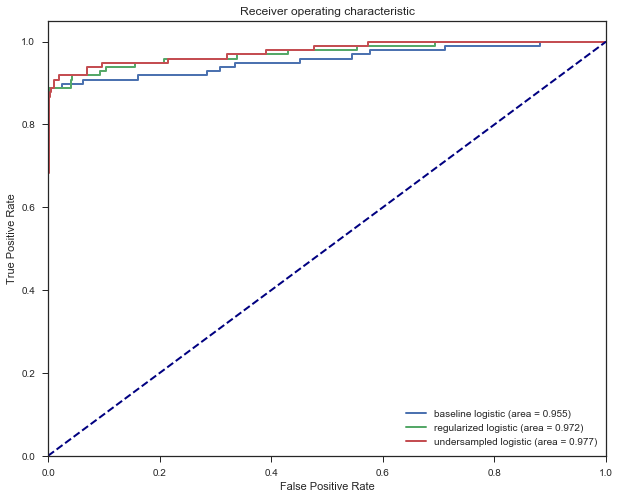

1

In [33]:
# train the model with C=100
logistic_mod_regularized_us = LogisticRegression(C=100, fit_intercept=True, penalty = 'l2')
logistic_mod_regularized_us.fit(X_train_us, y_train_us)
y_test_pred3 = logistic_mod_regularized_us.predict_proba(X_test)[:,1]

# draw the ROC
calc_roc([y_test,y_test,y_test], [y_test_pred, y_test_pred2, y_test_pred3],['baseline logistic', 'regularized logistic', 'undersampled logistic'])

### Undersampling makes the results better.

### Let's try to oversample the minority class

In [35]:
# perform oversampling to the minority class
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0) # with replacement by default
X_train_os, y_train_os = ros.fit_sample(X_train, y_train)
from collections import Counter
print(sorted(Counter(y_train_os).items()))



[(0, 227451), (1, 227451)]


In [36]:
## Tune the regularization parameter C
k = 5 # rounds of kfold-crossvalidation
Cs=list(np.power(10.0, np.arange(-5,5)))
logistic_cv_os = LogisticRegressionCV(Cs=Cs, fit_intercept=True, cv = k, penalty = 'l2', scoring='roc_auc')
logistic_cv_os.fit(X_train_os, y_train_os)

print ('Max auc_roc:', logistic_cv_os.scores_[1].max(), 'C=', logistic_cv_os.C_[0])

Max auc_roc: 0.989737170801455 C= 10000.0


The area under ROC for baseline logistic is 0.955.
The area under ROC for regularized logistic is 0.972.
The area under ROC for undersampled logistic is 0.977.
The area under ROC for oversampled logistic is 0.972.


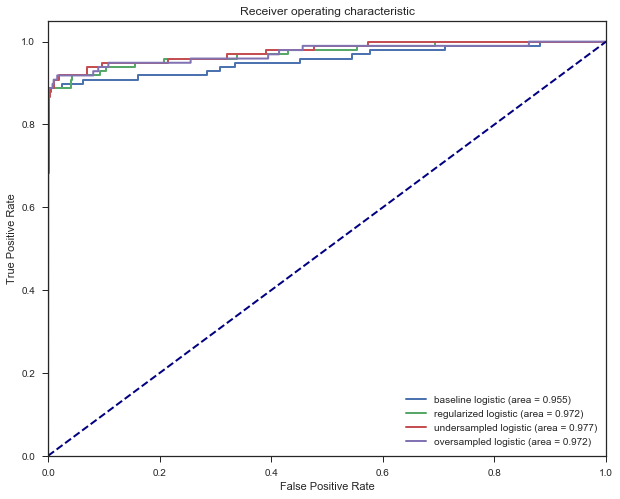

1

In [38]:
# train the model with C=10000
logistic_mod_regularized_os = LogisticRegression(C=10000, fit_intercept=True, penalty = 'l2')
logistic_mod_regularized_os.fit(X_train_os, y_train_os)
y_test_pred4 = logistic_mod_regularized_os.predict_proba(X_test)[:,1]

# draw the ROC
calc_roc([y_test,y_test,y_test,y_test], [y_test_pred, y_test_pred2, y_test_pred3, y_test_pred4],['baseline logistic', 'regularized logistic', 'undersampled logistic','oversampled logistic'])

# Undersampling improved the model, while oversamling not so much.
However, in the undersampling case, we loss over 99% of the training data for the normal behaviors. 
And, in the oversampling case, we repeat the fraudulent transactions again and again, which ctreated a lot of redundancies. 

## Is there a trade-off among these 2?

Let's test the middle ground, what happens if we have 2000 samples for each class.

In [72]:
from sklearn.utils import resample

N = 2000

# get the fraudulend transactions
X_train_pos = X_train[y_train==1]
X_train_neg = X_train[y_train==0]

# oversample the positive ones
X_train_pos_os = resample(X_train_pos, n_samples=N, replace=True)
#print (len(X_train_pos_os))

X_train_neg_us = resample(X_train_neg, n_samples=N)
#print (len(X_train_neg_us))

X_train_uos = pd.concat([X_train_pos_os, X_train_neg_us])
y_train_uos = pd.concat([pd.Series([1]*N), pd.Series([0]*N)])

from collections import Counter
print(sorted(Counter(y_train_uos).items()))



[(0, 2000), (1, 2000)]


In [73]:
## Tune the regularization parameter C
k = 5 # rounds of kfold-crossvalidation
Cs=list(np.power(10.0, np.arange(-5,5)))
logistic_cv_uos = LogisticRegressionCV(Cs=Cs, fit_intercept=True, cv = k, penalty = 'l2', scoring='roc_auc')
logistic_cv_uos.fit(X_train_uos, y_train_uos)

print ('Max auc_roc:', logistic_cv_uos.scores_[1].max(), 'C=', logistic_cv_uos.C_[0])

Max auc_roc: 0.9917875 C= 10000.0


The area under ROC for baseline logistic is 0.955.
The area under ROC for regularized logistic is 0.972.
The area under ROC for undersampled logistic is 0.977.
The area under ROC for oversampled logistic is 0.972.
The area under ROC for ous logistic is 0.974.


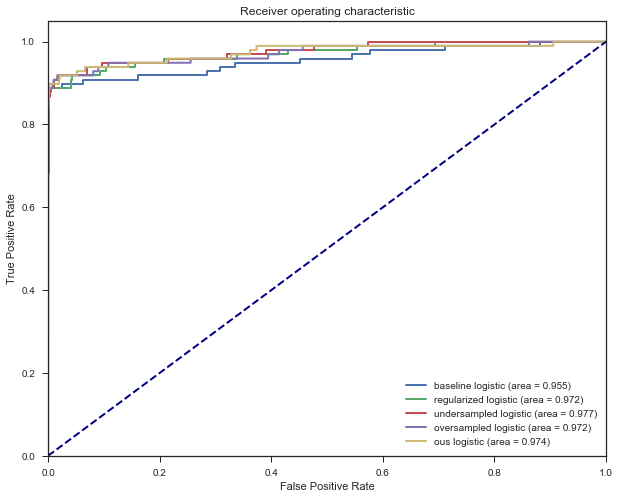

1

In [66]:
# train the model with C=1000
logistic_mod_regularized_uos = LogisticRegression(C=10000, fit_intercept=True, penalty = 'l2')
logistic_mod_regularized_uos.fit(X_train_uos, y_train_uos)
y_test_pred5 = logistic_mod_regularized_uos.predict_proba(X_test)[:,1]

# draw the ROC
calc_roc([y_test,y_test,y_test,y_test,y_test], 
         [y_test_pred, y_test_pred2, y_test_pred3, y_test_pred4, y_test_pred5],
         ['baseline logistic', 'regularized logistic', 'undersampled logistic','oversampled logistic','ous logistic'])

## Try find the best N

[0.969461059254878, 0.9727941999816245, 0.9764874013758571, 0.9637855054092543, 0.9680412735578192, 0.9688286875667544, 0.9706289909041839, 0.9732681198534562, 0.9709286676122333, 0.9692509266649822, 0.9714566010703662, 0.9698506389753425, 0.9734835461337039, 0.9735665404315919, 0.9699086003985162, 0.9718873639072961, 0.9730399528269383, 0.9720182705890459, 0.973047758777118, 0.9711440938924809, 0.9712859468491954, 0.9690954357263446, 0.9717983581305342, 0.9733752497904057, 0.971598543750646, 0.9713817716169191, 0.9707617817808046, 0.9720895110998817, 0.9702923480872372, 0.9714629714435015, 0.9728614926555879, 0.973513244633813, 0.9711982869259127, 0.9723312263847577, 0.9712648618113537, 0.9727943794287552, 0.971097706809229, 0.9717189527752575, 0.9712978800833785]


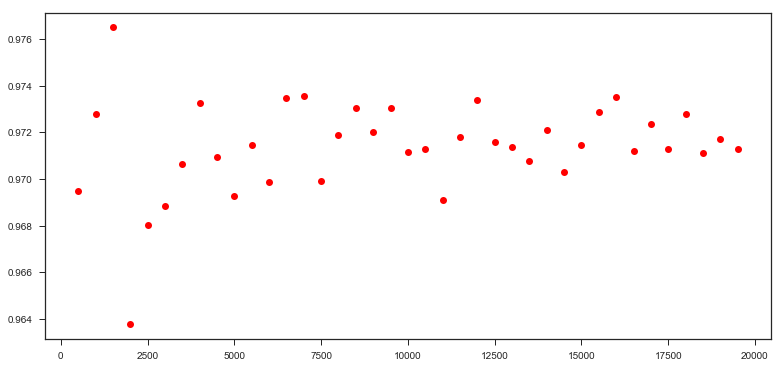

In [95]:
from sklearn.metrics import roc_curve,auc

Nlist = range(500,20000,500)
auclist = []


for N in Nlist:

    # get the fraudulend transactions
    X_train_pos = X_train[y_train==1]
    X_train_neg = X_train[y_train==0]

    # oversample the positive ones
    X_train_pos_os = resample(X_train_pos, n_samples=N, replace=True)
    #print (len(X_train_pos_os))

    X_train_neg_us = resample(X_train_neg, n_samples=N)
    #print (len(X_train_neg_us))

    X_train_uos = pd.concat([X_train_pos_os, X_train_neg_us])
    y_train_uos = pd.concat([pd.Series([1]*N), pd.Series([0]*N)])
    
    ## Tune the regularization parameter C
    k = 5 # rounds of kfold-crossvalidation
    Cs=list(np.power(10.0, np.arange(-5,5)))
    logistic_cv_uos = LogisticRegressionCV(Cs=Cs, fit_intercept=True, cv = k, penalty = 'l2', scoring='roc_auc')
    logistic_cv_uos.fit(X_train_uos, y_train_uos)
    
    Cc = logistic_cv_uos.C_[0]

    logistic_mod_regularized_uos = LogisticRegression(C=Cc, fit_intercept=True, penalty = 'l2')
    logistic_mod_regularized_uos.fit(X_train_uos, y_train_uos)
    y_test_pred5 = logistic_mod_regularized_uos.predict_proba(X_test)[:,1]
    
    #calculate auc
    
    false_positive_rate, recall, thresholds = roc_curve(y_test, y_test_pred5)
    #auc = auc(false_positive_rate,recall)
    auclist.append(auc(false_positive_rate,recall))
    #print(auc(false_positive_rate,recall))

    
import matplotlib.pyplot as plt
plt.plot(Nlist, auclist, 'ro' )
print(auclist)


## 7. Algorithmic level method
## We will apply the simplist and fastest method, which is class weights in training the model.

In [49]:
# class weights in training

## Tune the regularization parameter C
k = 5 # rounds of kfold-crossvalidation
Cs=list(np.power(10.0, np.arange(-5,5)))
logistic_cv_weights = LogisticRegressionCV(Cs=Cs, fit_intercept=True, cv = k, penalty = 'l2', scoring='roc_auc', 
                                           class_weight='balanced')
logistic_cv_weights.fit(X_train, y_train)

print ('Max auc_roc:', logistic_cv_weights.scores_[1].max(), 'C=', logistic_cv_weights.C_[0])

Max auc_roc: 0.9931512138480703 C= 1.0


The area under ROC for baseline logistic is 0.955.
The area under ROC for regularized logistic is 0.972.
The area under ROC for undersampled logistic is 0.977.
The area under ROC for oversampled logistic is 0.972.
The area under ROC for ous logistic is 0.973.
The area under ROC for class weighted logistic is 0.974.


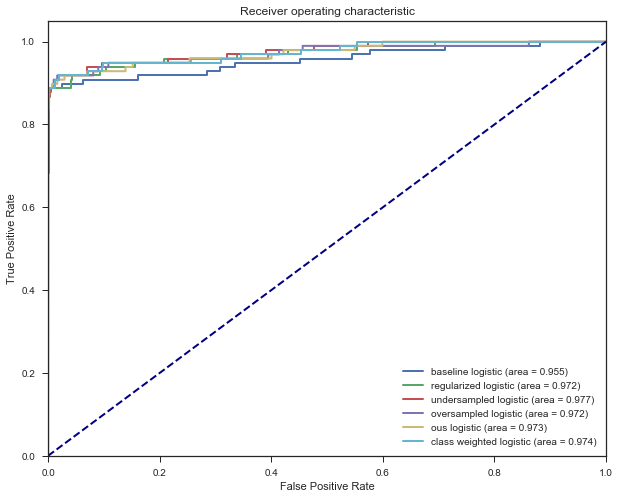

1

In [50]:
# train the model with C=1
logistic_mod_weights = LogisticRegression(C=1, fit_intercept=True, penalty = 'l2', 
                                                  class_weight = 'balanced')
logistic_mod_weights.fit(X_train, y_train)
y_test_pred6 = logistic_mod_weights.predict_proba(X_test)[:,1]

# draw the ROC
calc_roc([y_test,y_test,y_test,y_test,y_test,y_test], 
         [y_test_pred, y_test_pred2, y_test_pred3, y_test_pred4, y_test_pred5, y_test_pred6],
         ['baseline logistic', 'regularized logistic', 'undersampled logistic','oversampled logistic','ous logistic','class weighted logistic'])

## 8. Try out decision tree algorithm 

In [96]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

In [97]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [98]:
clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=3, min_samples_leaf=5)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [99]:
y_pred = clf_gini.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [100]:
y_pred_en = clf_entropy.predict(X_test)
y_pred_en

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [101]:
print ("Accuracy is ", accuracy_score(y_test,y_pred)*100)

Accuracy is  99.92275552122467


In [102]:
print ("Accuracy is ", accuracy_score(y_test,y_pred_en)*100)

Accuracy is  99.93504441557529


In [125]:
# check the confusion matrix
pd.crosstab(y_test,y_pred,margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,All
Actual,,,
0,56843,21,56864
1,23,75,98
All,56866,96,56962


In [126]:
# check the confusion matrix
pd.crosstab(y_test,y_pred_en,margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,All
Actual,,,
0,56845,19,56864
1,18,80,98
All,56863,99,56962


# Using information gain as a criterion is better than using gini, and

# Decision Tree algorithm in general gives a better result than Logistic 

# Regression.

## Try undersampling/oversampling

First try undersampling 

In [105]:
clf_gini_us = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini_us.fit(X_train_us, y_train_us)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [106]:
clf_entropy_us = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=3, min_samples_leaf=5)
clf_entropy_us.fit(X_train_us, y_train_us)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [108]:
y_pred_us = clf_gini_us.predict(X_test)
y_pred_us

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [117]:
y_pred_en_us = clf_entropy_us.predict(X_test)
y_pred_en_us

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [122]:
print ("Accuracy is ", accuracy_score(y_test,y_pred_us)*100)

Accuracy is  95.99733155436958


In [111]:
print ("Accuracy is ", accuracy_score(y_test,y_pred_en_us)*100)

Accuracy is  98.09522137565394


Undersampling doesn't improve the result.
Let's try oversampling.

In [114]:
clf_gini_os = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf_gini_os.fit(X_train_os, y_train_os)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [120]:
clf_entropy_os = DecisionTreeClassifier(criterion = "entropy", random_state = 100,
 max_depth=3, min_samples_leaf=5)
clf_entropy_os.fit(X_train_os, y_train_os)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [118]:
y_pred_os = clf_gini_os.predict(X_test)
y_pred_os

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [121]:
y_pred_en_os = clf_entropy_os.predict(X_test)
y_pred_en_os

array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [123]:
print ("Accuracy is ", accuracy_score(y_test,y_pred_os)*100)

Accuracy is  96.89090972929321


In [124]:
print ("Accuracy is ", accuracy_score(y_test,y_pred_en_os)*100)

Accuracy is  92.99006355113936


# Result: Undersampling/oversampling cannot improve the model as for decision tree algorithm.